# ___CIFAR10___
-----------------

In [1]:
!python --version

Python 3.13.4


In [137]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch
# https://en.wikipedia.org/wiki/Kernel_(image_processing)

In [122]:
import os
import pickle
from typing import override
from PIL import Image
import gc

import numpy as np
np.random.seed(2025 - 6 - 17)
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [2]:
os.listdir(r"./cifar-10-batches-py/")

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [3]:
# CIFAR10 metedata

with open(file=r"./cifar-10-batches-py/batches.meta", mode="rb") as fp:
    cifar10_metadata = pickle.load(fp)

cifar10_metadata

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

In [4]:
# image batches
os.listdir(r"./cifar-10-batches-py/")[1:6]

['data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5']

In [5]:
cifar10_batches_unpickled = []

for batch_name in os.listdir(r"./cifar-10-batches-py/")[1:6]:
    with open(file=f"./cifar-10-batches-py/{batch_name}", mode="rb") as fp:
        cifar10_batches_unpickled.append(pickle.load(fp, encoding="bytes"))

In [6]:
with open(file=r"./cifar-10-batches-py/test_batch", mode="rb") as fp:
    cifar10_test_unpickled = pickle.load(fp, encoding="bytes")

In [7]:
len(cifar10_batches_unpickled)

5

In [8]:
cifar10_test_unpickled;

In [9]:
list(map(lambda _: _.keys(), cifar10_batches_unpickled))

[dict_keys([b'batch_label', b'labels', b'data', b'filenames']),
 dict_keys([b'batch_label', b'labels', b'data', b'filenames']),
 dict_keys([b'batch_label', b'labels', b'data', b'filenames']),
 dict_keys([b'batch_label', b'labels', b'data', b'filenames']),
 dict_keys([b'batch_label', b'labels', b'data', b'filenames'])]

In [10]:
list(map(lambda _: _.get(b"batch_label"), cifar10_batches_unpickled))

[b'training batch 1 of 5',
 b'training batch 2 of 5',
 b'training batch 3 of 5',
 b'training batch 4 of 5',
 b'training batch 5 of 5']

In [11]:
# the first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue
cifar10_batches_unpickled[0][b"data"]

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]],
      shape=(10000, 3072), dtype=uint8)

In [12]:
32*32

1024

In [13]:
np.column_stack(cifar10_batches_unpickled[0][b"data"][0].reshape((3, 1024)))

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       ...,
       [216, 184, 140],
       [151, 118,  84],
       [123,  92,  72]], shape=(1024, 3), dtype=uint8)

In [14]:
np.column_stack(cifar10_batches_unpickled[0][b"data"][0].reshape((3, 1024))).reshape((32, 32, 3))

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [15]:
np.random.randint(low=0, high=5)

1

In [17]:
np.where(np.array(cifar10_batches_unpickled[0][b"labels"]) == 8)[0]

array([   8,   62,   69, ..., 9960, 9972, 9975], shape=(1025,))

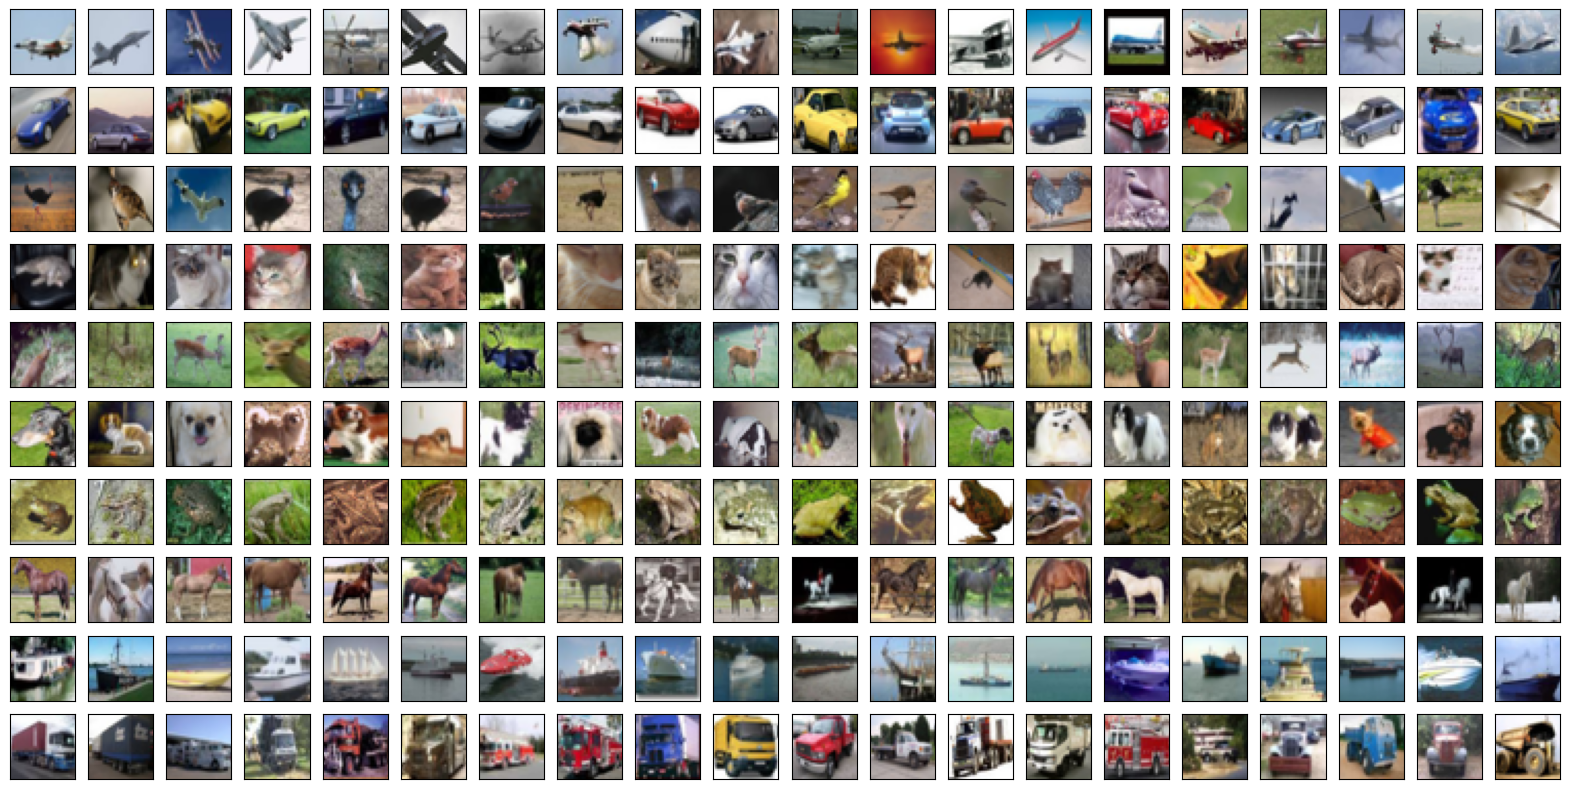

In [18]:
fig, axes = plt.subplots(nrows=10, ncols=20)
fig.set_size_inches(20, 10)
for (LABEL_GROUP, row) in enumerate(axes):
    BATCH_NO = np.random.randint(low=0, high=5)
    SELECTED_IMAGE_GROUP_OFFSETS = np.where(np.array(cifar10_batches_unpickled[BATCH_NO][b"labels"]) == LABEL_GROUP)[0]
    for axis in row:
        axis.imshow(
            np.column_stack(
                cifar10_batches_unpickled[BATCH_NO][b"data"][np.random.choice(SELECTED_IMAGE_GROUP_OFFSETS)].reshape((3, 1024))
            ).reshape((32, 32, 3))
        )
        axis.set_xticks([])
        axis.set_yticks([])
plt.show()

In [136]:
# define our CNN

class Cifar10CNN(nn.Module):

    @override
    def __init__(self, nclasses: int) -> None:
        super(Cifar10CNN, self).__init__()

        self.__n_classes: int = nclasses
        self.__conv_layer_01 = nn.Conv2d(kernel_size=3, # 3 x 3 convolution kernel
                                         in_channels=3, # R, G & B
                                         out_channels=32)
        
        self.__conv_layer_02 = nn.Conv2d(kernel_size=3, # 3 x 3 convolution kernel
                                         in_channels=32, # out channels of the previous layer
                                         out_channels=32)

In [153]:
# what does a convolution kernel do to an image???

image = np.array(Image.open(r"./colors.jpg"))

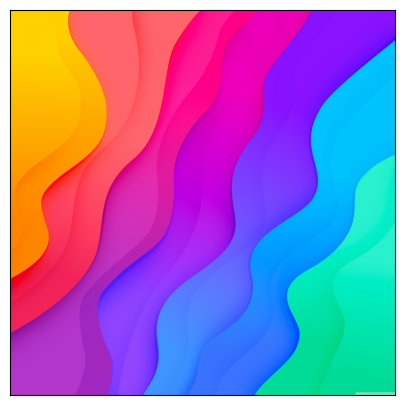

In [154]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
axes.imshow(image)
axes.set_xticks([])
axes.set_yticks([])
plt.show()

In [219]:
image.shape

(3840, 3840, 3)

In [220]:
image

array([[[254, 208,   0],
        [254, 208,   0],
        [254, 208,   0],
        ...,
        [137,  17, 254],
        [137,  17, 254],
        [137,  17, 254]],

       [[254, 208,   0],
        [254, 208,   0],
        [254, 208,   0],
        ...,
        [138,  18, 255],
        [138,  18, 255],
        [138,  18, 255]],

       [[255, 209,   1],
        [255, 209,   1],
        [255, 209,   1],
        ...,
        [138,  18, 255],
        [138,  18, 255],
        [138,  18, 255]],

       ...,

       [[178,  54, 204],
        [178,  54, 204],
        [178,  54, 204],
        ...,
        [137, 225, 200],
        [137, 225, 200],
        [137, 225, 200]],

       [[179,  55, 205],
        [178,  54, 204],
        [178,  54, 204],
        ...,
        [137, 225, 200],
        [137, 225, 200],
        [137, 225, 200]],

       [[179,  55, 205],
        [178,  54, 204],
        [177,  53, 203],
        ...,
        [137, 225, 200],
        [137, 225, 200],
        [137, 225, 200]]

In [155]:
# torch.tensor(image, dtype=torch.float32)#.shape

In [156]:
torch.tensor(image, dtype=torch.float32).shape

torch.Size([3840, 3840, 3])

In [157]:
# transform this into 3 (RGB) 3840 x 3840 matrices

rgb_image = np.column_stack(np.vstack(image)).reshape((3, 3840, 3840))

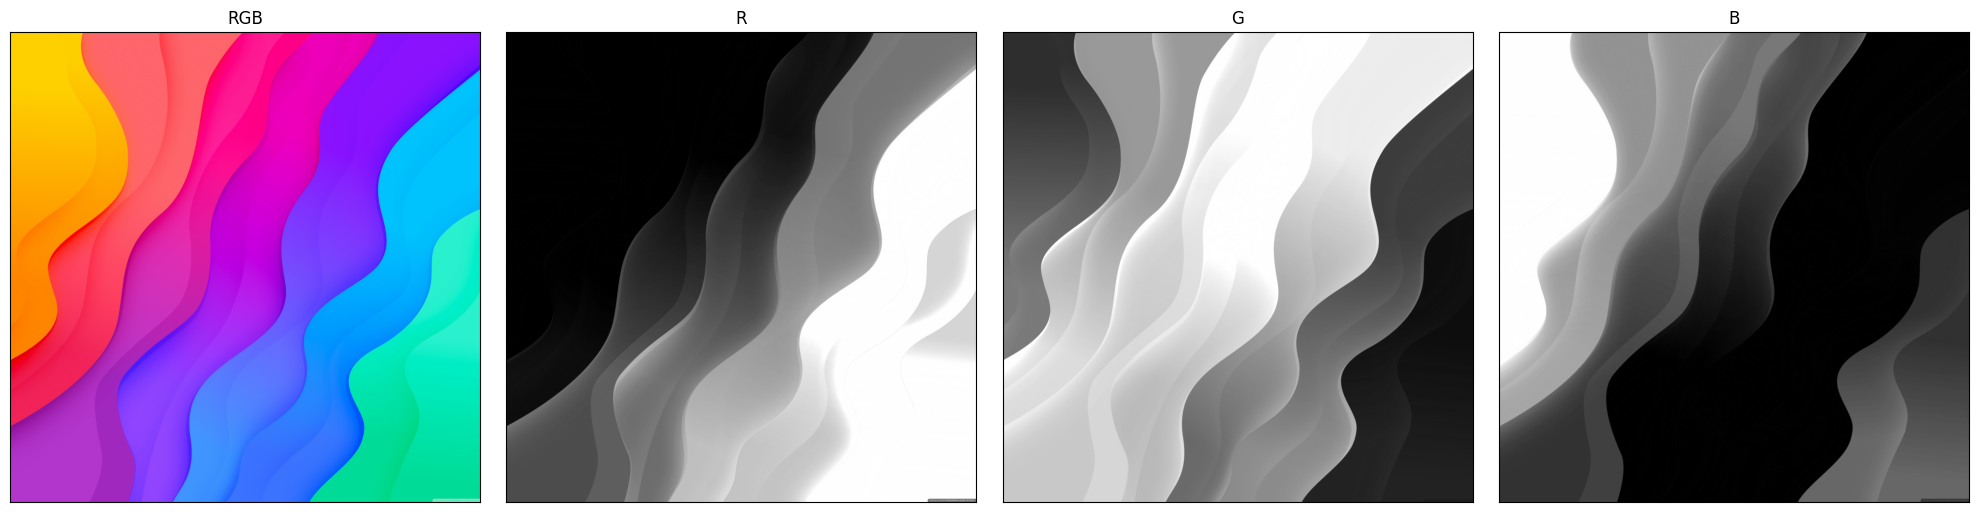

In [169]:
fig, (first, *axes) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)

first.imshow(image)
first.set_xticks([])
first.set_yticks([])
first.set_title("RGB")

for (i, axis, label) in zip(range(3), axes, ('R', 'G', 'B')):
    axis.imshow(rgb_image[i], cmap="binary")
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(label)

plt.tight_layout()
plt.show()

In [232]:
rgb_tensor = torch.tensor(rgb_image, dtype=torch.float32)

In [234]:
3840 / 40

96.0

In [258]:
convolved = nn.Conv2d(in_channels=3, kernel_size=(40, 40), out_channels=3)(rgb_tensor).detach().numpy()

In [259]:
convolved.shape

(3, 3801, 3801)

In [260]:
convolved[0]

array([[-146.78424 , -147.02315 , -147.22145 , ...,  -55.65073 ,
         -55.687824,  -55.806313],
       [-146.60722 , -147.0549  , -147.18927 , ...,  -56.031536,
         -55.753872,  -55.65478 ],
       [-147.2084  , -147.3808  , -147.18176 , ...,  -56.189785,
         -56.24924 ,  -56.11523 ],
       ...,
       [ -80.446   ,  -80.17443 ,  -80.16008 , ...,  -92.97202 ,
        -100.206535, -108.48849 ],
       [ -80.19059 ,  -80.43803 ,  -80.498856, ..., -104.158195,
        -106.11225 , -111.00473 ],
       [ -80.47334 ,  -80.30805 ,  -80.36853 , ..., -106.851845,
        -104.98199 , -102.262596]], shape=(3801, 3801), dtype=float32)

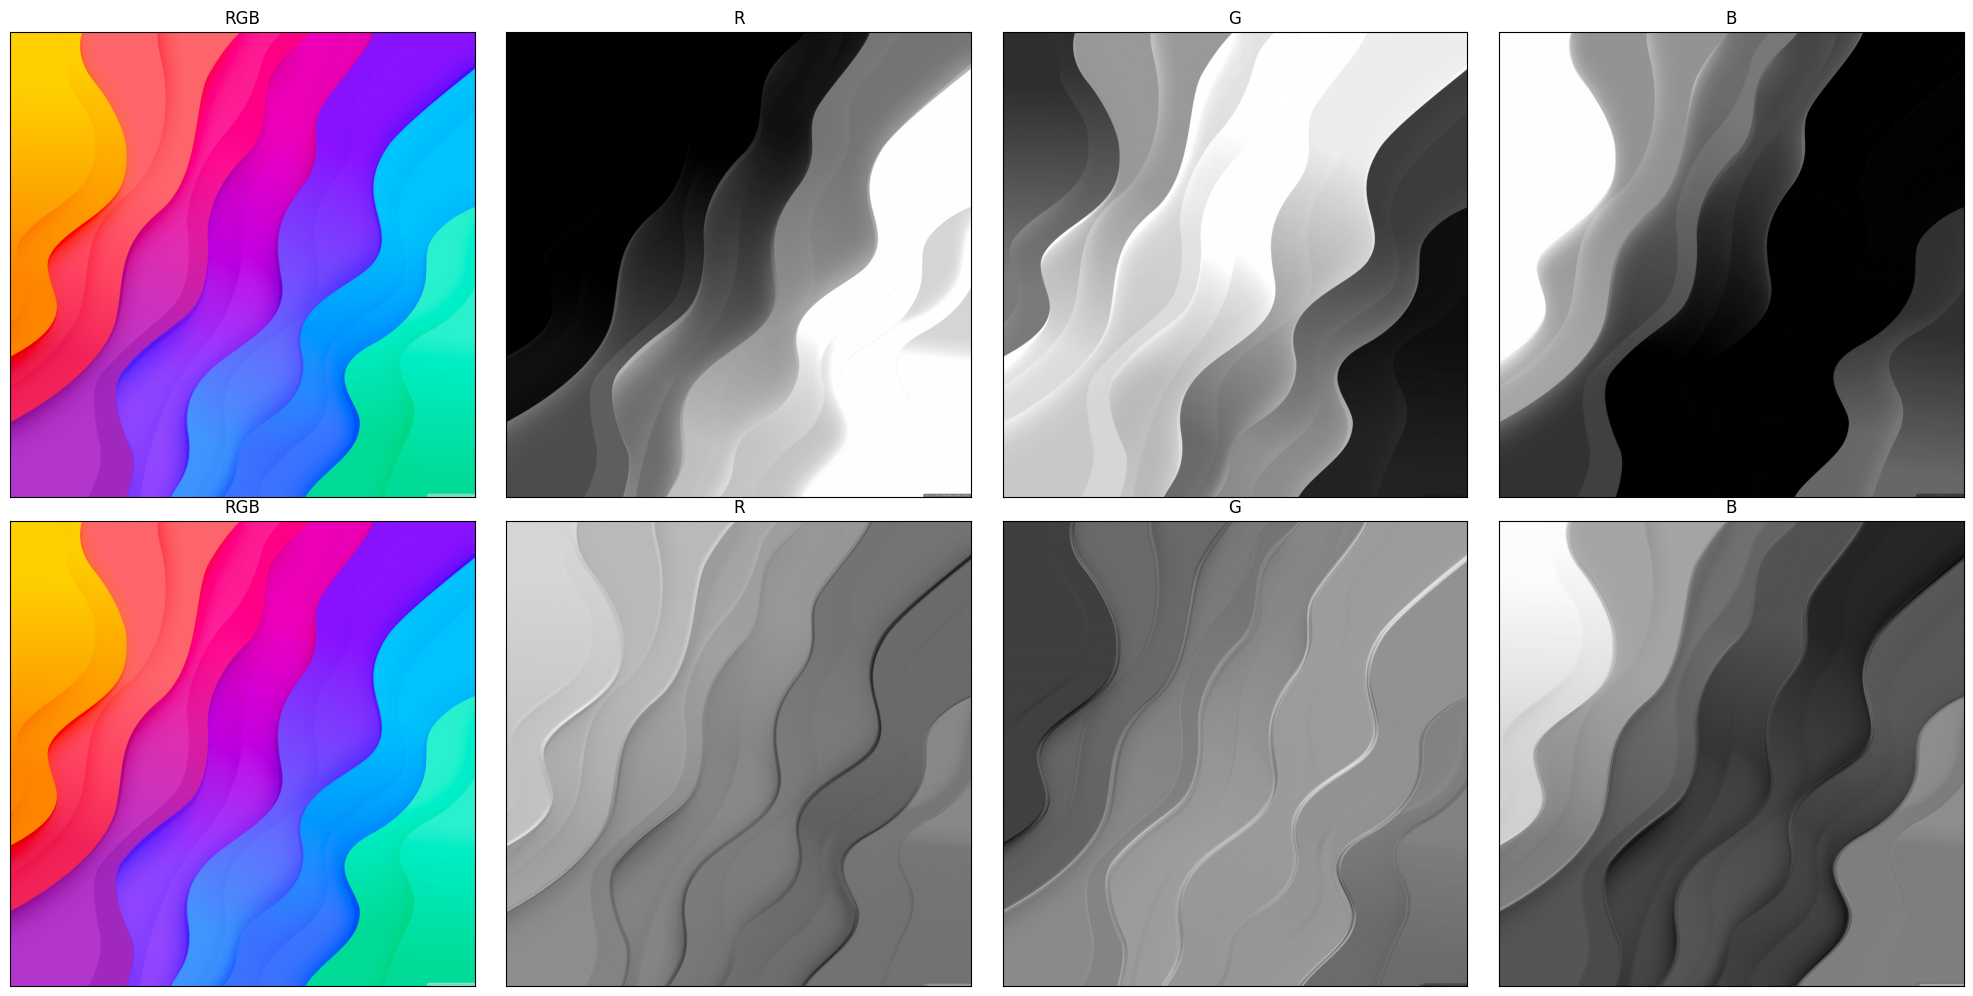

In [269]:
fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 10)

axes[0][0].imshow(image)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[1][0].imshow(image)
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])

# axes[0].set_suptitle("Pre-convolution")
for (i, axis, label) in zip(range(4), axes[0], ("RGB", 'R', 'G', 'B')):
    axis.imshow(rgb_image[i-1] if i else image, cmap="binary")
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(label)

# axes[1].set_suptitle("Post-convolution")
for (i, axis, label) in zip(range(4), axes[1], ("RGB", 'R', 'G', 'B')):
    axis.imshow(convolved[i-1] if i else image, cmap="binary")
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(label)

plt.tight_layout()
plt.show()

In [274]:
[gc.collect(_) for _ in range(3)]

[0, 0, 0]

# ___Root Images___
-----------------------

In [19]:
# repeat the same with root images

cowpea_roots = [np.array(Image.open(f"./cowpea/{fname}")) for fname in os.listdir(r"./cowpea/")]

In [23]:
len(os.listdir(r"./cowpea/"))

100

In [24]:
cowpea_roots[0].shape

(3078, 2207, 3)

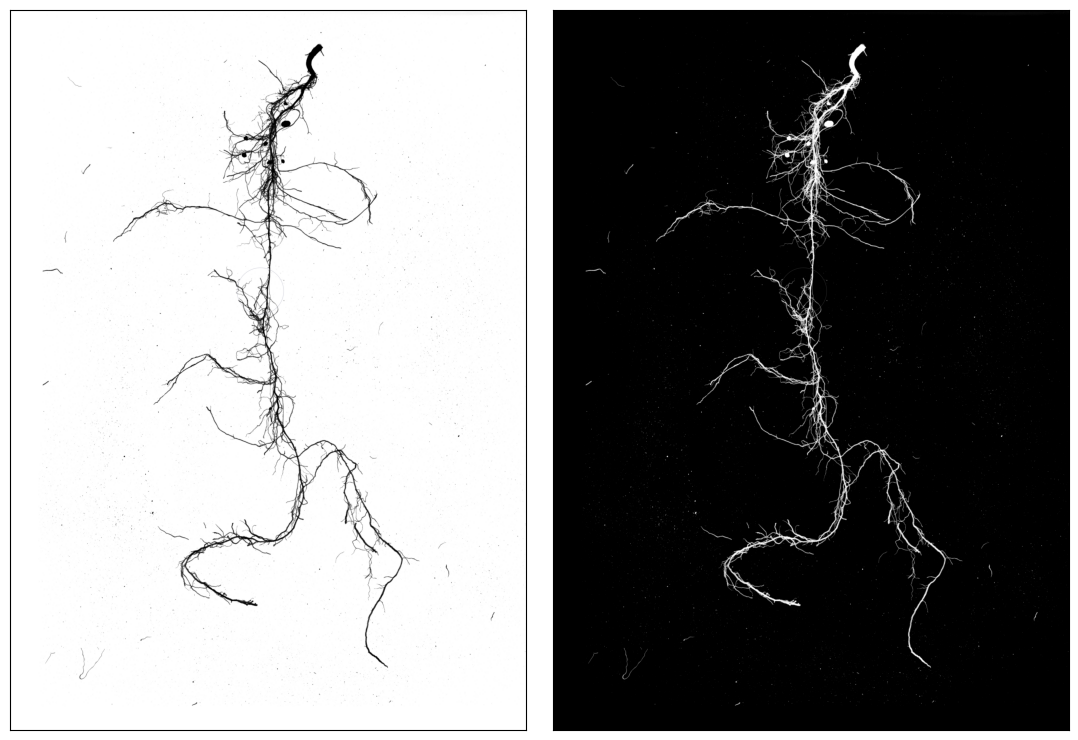

In [57]:
fig, (axis_l, axis_r) = plt.subplots(ncols=2, sharex=True, sharey=True)
fig.set_size_inches(11, 7.5)

axis_l.imshow(cowpea_roots[0])
axis_l.set_xticks([])
axis_l.set_yticks([])

axis_r.imshow(cowpea_roots[0].mean(axis=2), cmap="binary")
axis_r.set_xticks([])
axis_r.set_yticks([])

plt.tight_layout()
plt.show()

In [53]:
cowpea_roots[0].mean(axis=2)

array([[255., 255., 255., ..., 254., 252., 237.],
       [255., 255., 255., ..., 254., 254., 241.],
       [255., 255., 255., ..., 253., 253., 241.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], shape=(3078, 2207))

In [76]:
3078 * 2207

6793146

(array([[255, 255, 255, ..., 254, 252, 237],
        [255, 255, 255, ..., 254, 254, 241],
        [255, 255, 255, ..., 253, 253, 241],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],
       shape=(3078, 2207), dtype=uint8),
 array([[255, 255, 255, ..., 254, 252, 237],
        [255, 255, 255, ..., 254, 254, 241],
        [255, 255, 255, ..., 253, 253, 241],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],
       shape=(3078, 2207), dtype=uint8),
 array([[255, 255, 255, ..., 254, 252, 237],
        [255, 255, 255, ..., 254, 254, 241],
        [255, 255, 255, ..., 253, 253, 241],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],
       shape=(3078, 2207), dtype=uint8))

In [64]:
cowpea_roots[0].reshape(3, 3078, 2207)

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 237, 237, 237],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 244, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 228, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 208, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 243, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]],
      shape=(3, 3078, 2207), dtype=uint8)

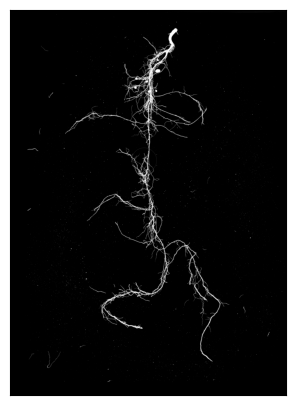

In [85]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
axes.imshow(np.unstack(cowpea_roots[0], axis=2)[0], cmap="binary")
axes.set_xticks([])
axes.set_yticks([])
plt.show()

In [174]:
convoluted_roots = []

with torch.no_grad():
    for root in cowpea_roots[:5]:
        temp = nn.Conv2d(kernel_size=(10, 10), in_channels=3, out_channels=3)(torch.tensor(np.unstack(root, axis=2), dtype=torch.float32)).numpy()
        # print("Before ", temp.min())
        temp += abs(temp.min())
        # print("After ", temp.min())
        temp /= temp.max()
        convoluted_roots.append(temp)

In [176]:
convoluted_roots[0].min()

np.float32(0.0)

In [177]:
np.stack(convoluted_roots[0], axis=-1).min(), np.stack(convoluted_roots[0], axis=-1).max()

(np.float32(0.0), np.float32(1.0))

In [178]:
convoluted_roots[0].min(), convoluted_roots[0].max()

(np.float32(0.0), np.float32(1.0))

In [189]:
np.stack(convoluted_roots[0], axis=-1)

array([[[0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        ...,
        [0.31837338, 0.188662  , 0.60913956],
        [0.32033086, 0.19464657, 0.6113736 ],
        [0.3250577 , 0.19792326, 0.61774796]],

       [[0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        ...,
        [0.31605488, 0.18725494, 0.60956544],
        [0.31972483, 0.1947322 , 0.610175  ],
        [0.32606724, 0.1935397 , 0.60988545]],

       [[0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        ...,
        [0.31539473, 0.18660672, 0.6117859 ],
        [0.3194324 , 0.19209188, 0.6122138 ],
        [0.32231438, 0.1920282 , 0.6134385 ]],

       ...,

       [[0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0.171132  , 0.6029619 ],
        [0.30225208, 0

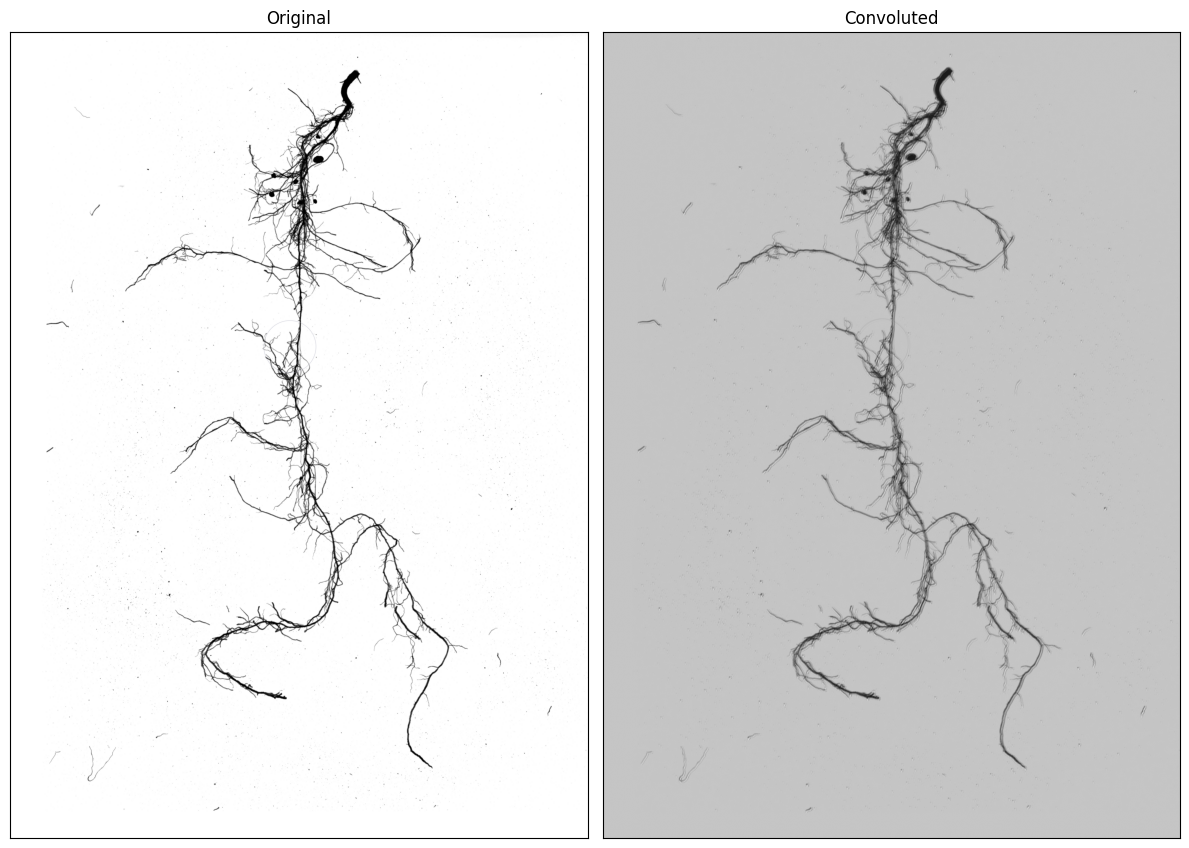

In [196]:
fig, (axis_l, axis_r) = plt.subplots(ncols=2)
fig.set_size_inches(12, 9)

axis_l.imshow(cowpea_roots[0], cmap="binary")
axis_l.set_xticks([])
axis_l.set_yticks([])
axis_l.set_title("Original")

axis_r.imshow(np.stack(convoluted_roots[0], axis=-1).mean(axis=2), cmap="binary")
axis_r.set_xticks([])
axis_r.set_yticks([])
axis_r.set_title("Convoluted")

plt.tight_layout()
plt.show()